# Processing of the Data Science Bowl 2012 kaggle dataset with u-net neuron network

In [1]:
%matplotlib inline 
import matplotlib
import keras
import sys
import os
from glob import glob
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("data")
from data.data_helper import show_data_from_generator
from models.unet import *
from data.dsb import DataScienceBowl2018
from data.dataset import Dataset
from callbacks import ImageHistory

Using TensorFlow backend.


## Directories

In [2]:
# location where the dataset will be downloaded
dataset_location = './data/datasets/data-science-bowl-2018'
tensor_board_directory = './logs'
weight_file = './unet_dsb_weights.hdf5'

## Parameters

In [3]:
learning_rate = 1e-4
input_shape=(256,256,1)
loss = 'binary_crossentropy'
steps_per_epoch = 4000
epochs = 3
batch_size = 20
start_epoch = 0
last_step = 0
clear_all = True
prepare_dataset = True

## Clear data from previous executions if needed

In [4]:
if clear_all:
    if os.path.exists(weight_file):
        os.remove(weight_file)
    files = glob(tensor_board_directory +'/*')
    for f in files:
        os.remove(f)

## Setup dataset
The dataset contains tissue scans and binary masks for identification of nuclei. Each mask contains shape of a single nucleus.
The dataset is available through WEB site https://www.kaggle.com/c/data-science-bowl-2018. Dataset class uses kaggle API for 
downloading of the data. It requires a kaggle account. See https://github.com/Kaggle/kaggle-api for details.

This section performs following operations:
- downloading of the dataset;
- combination of a slide masks in a single mask with outlines of all slide nuclei;
- invert bright slides;
- defines the training, validation and test datasets by clustering of images according to the image raster statistics and making sure that each set contains equal amount of images from the clusters; 
- splits slides to tiles 256x256. The tiles normally overlap with each other;

For the more detailed information see notebook ./data/data-science-bowl.ipynb.

In [5]:
dataset = DataScienceBowl2018(dataset_location)

In [6]:
if prepare_dataset:
    dataset.clear()
    dataset.download()
    dataset.prepare()

### Show original images (not preprocessed)
This section shows several original slides and corresponded nucleus masks. The masks are already combined together. One row shows images, anoter corresponded masks.

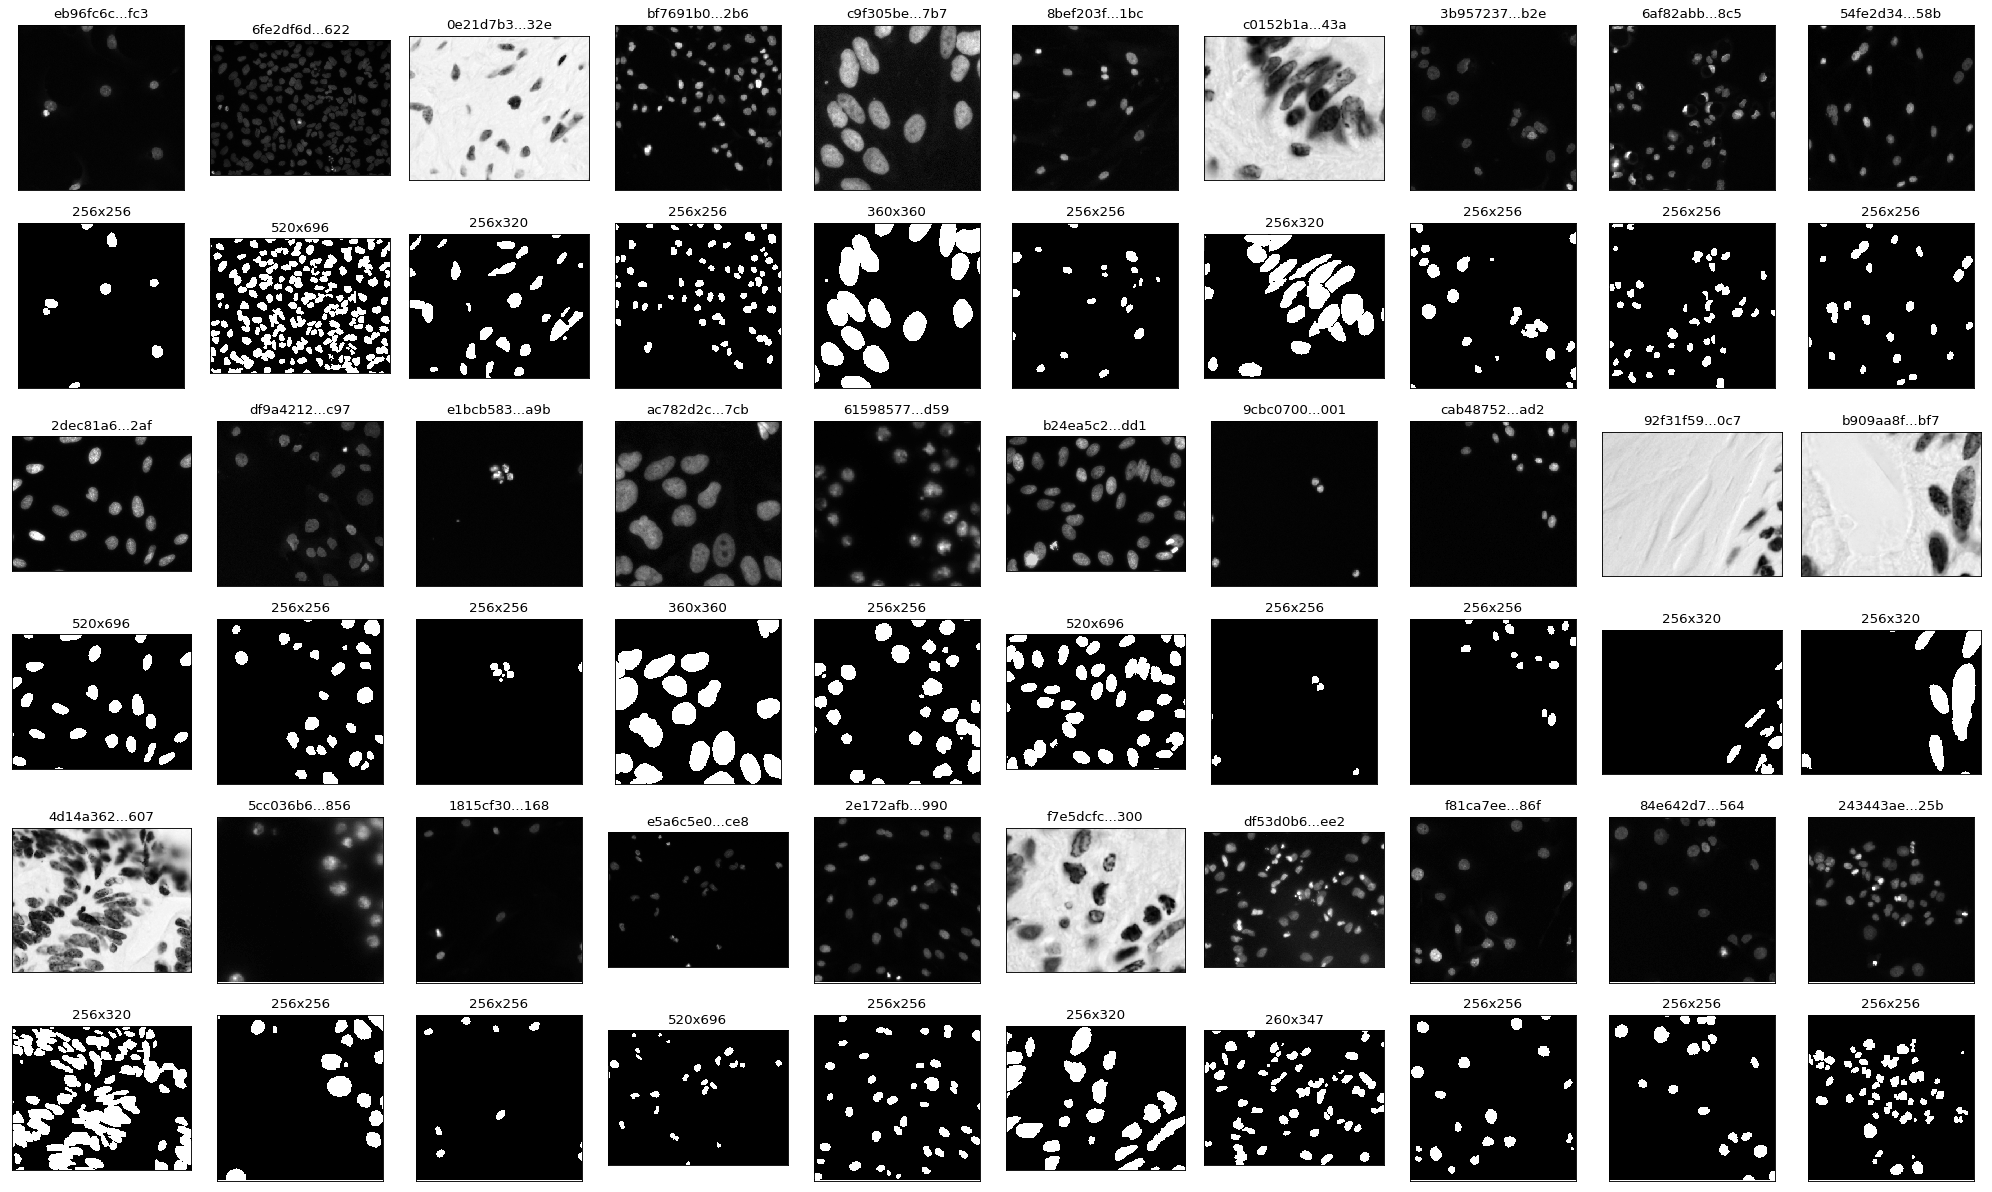

In [7]:
generator = dataset.source_generator()
show_data_from_generator(generator,3, 10, (25,15))

### Show some preprocessed training images
This section shows 256x256 tiles created from the original images together with corresponded masks

Found 1949 images belonging to 1 classes.
Found 1949 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


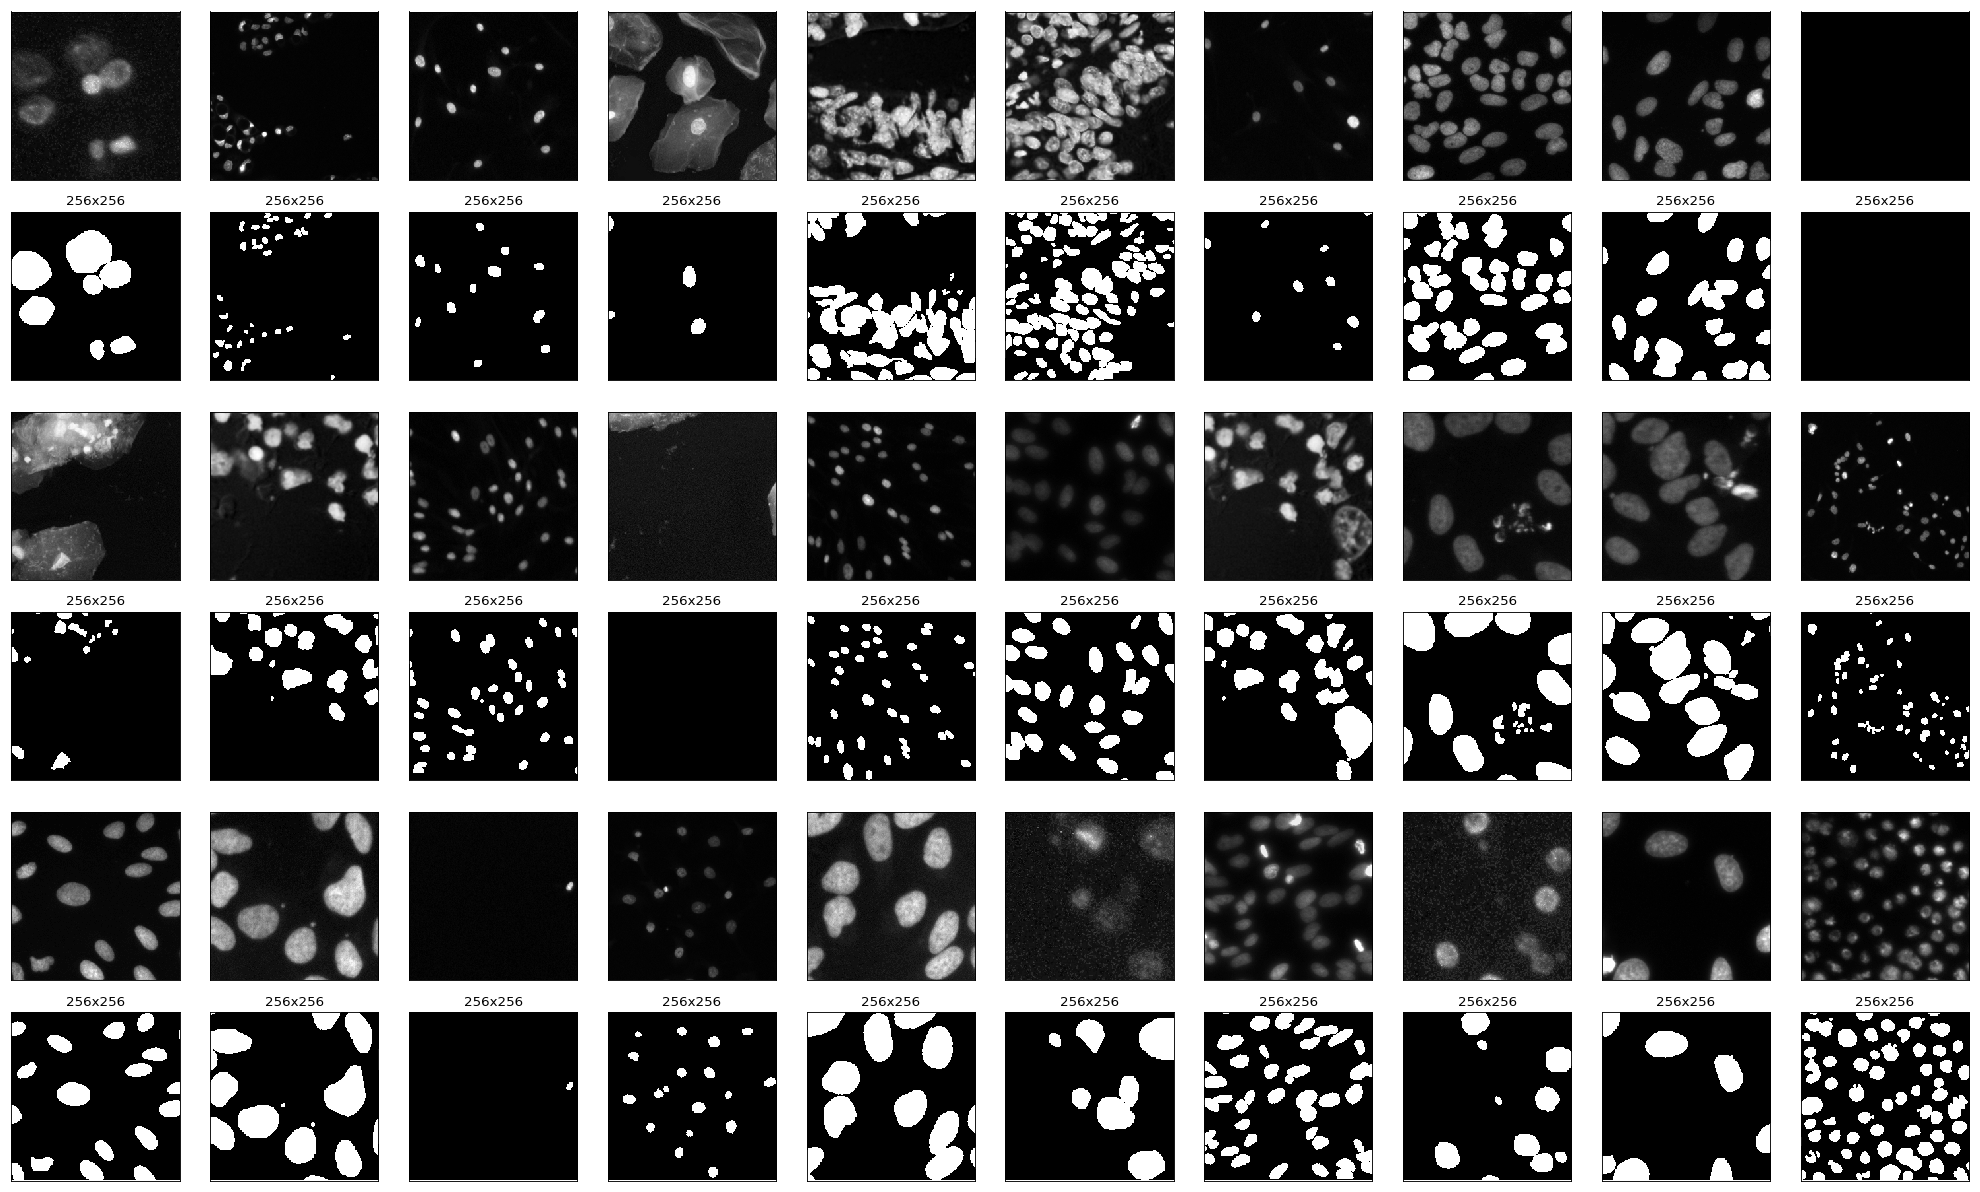

In [8]:
generator = dataset.generator(mode='training')
show_data_from_generator(generator,3, 10, (25,15))

### Show some preprocessed validation images
This section shows several images and masks from the validation set

Found 228 images belonging to 1 classes.
Found 228 images belonging to 1 classes.


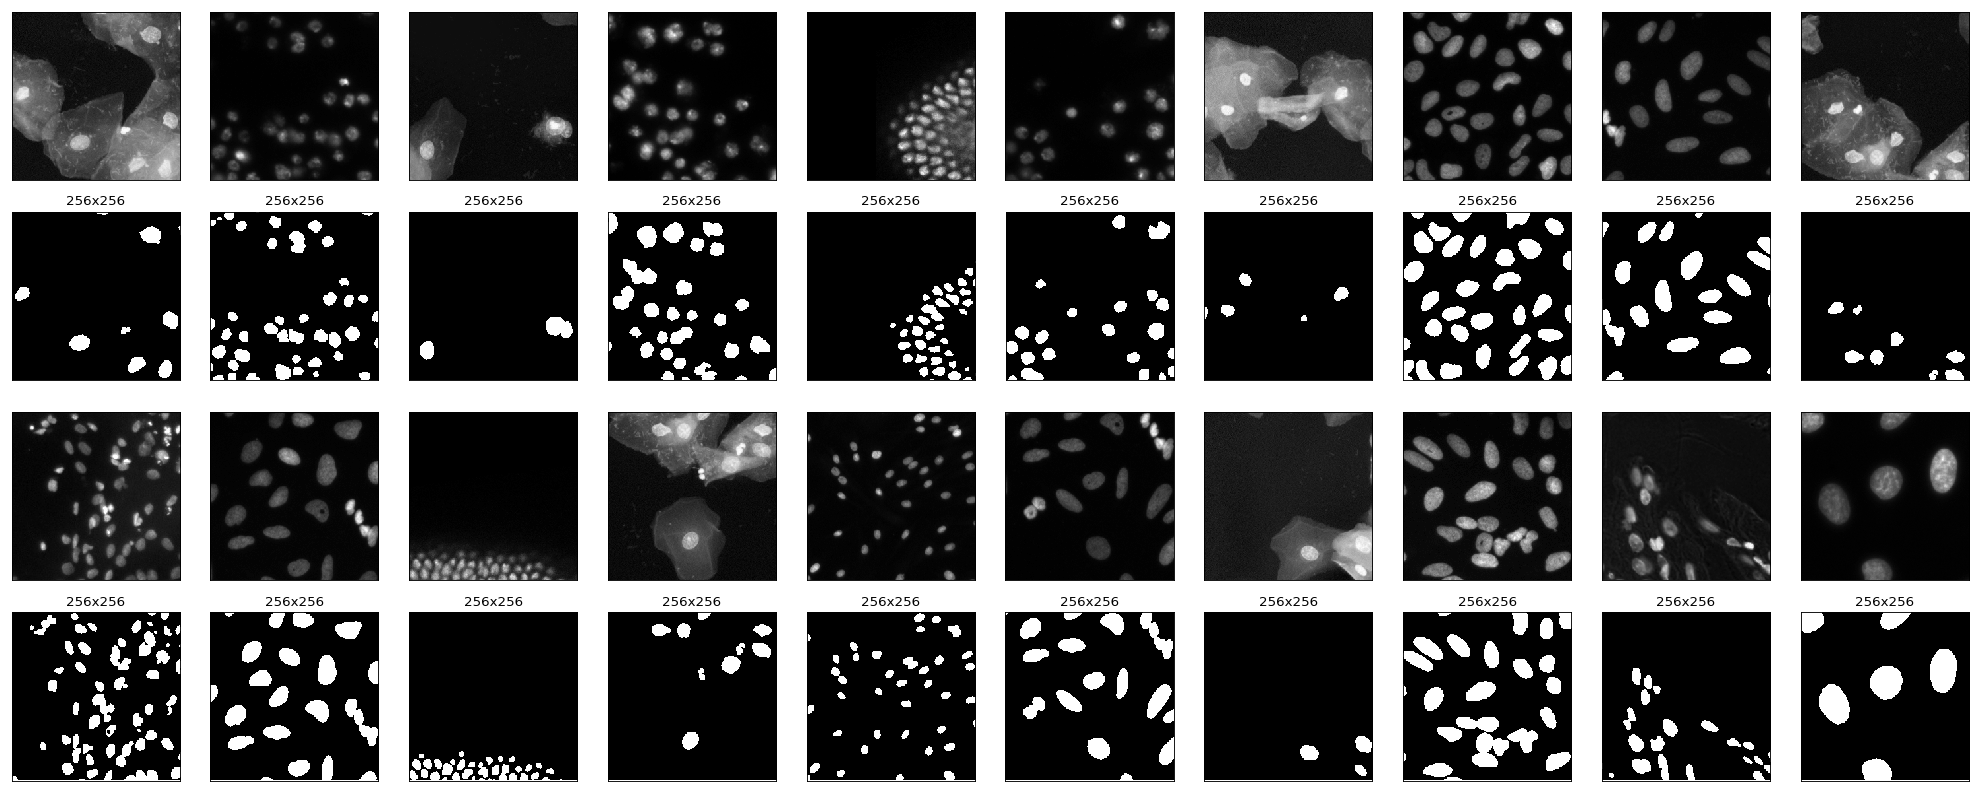

In [9]:
generator = dataset.generator(mode='validation')
show_data_from_generator(generator,2, 10, (25, 10))

### Show some testing images (not preprocessed)
This section shows test images and corresponded nucleus masks. The images are not tiled nor preprocess. Tiling, preprocessing and combining of the prediction results occurs in the inferrence process.

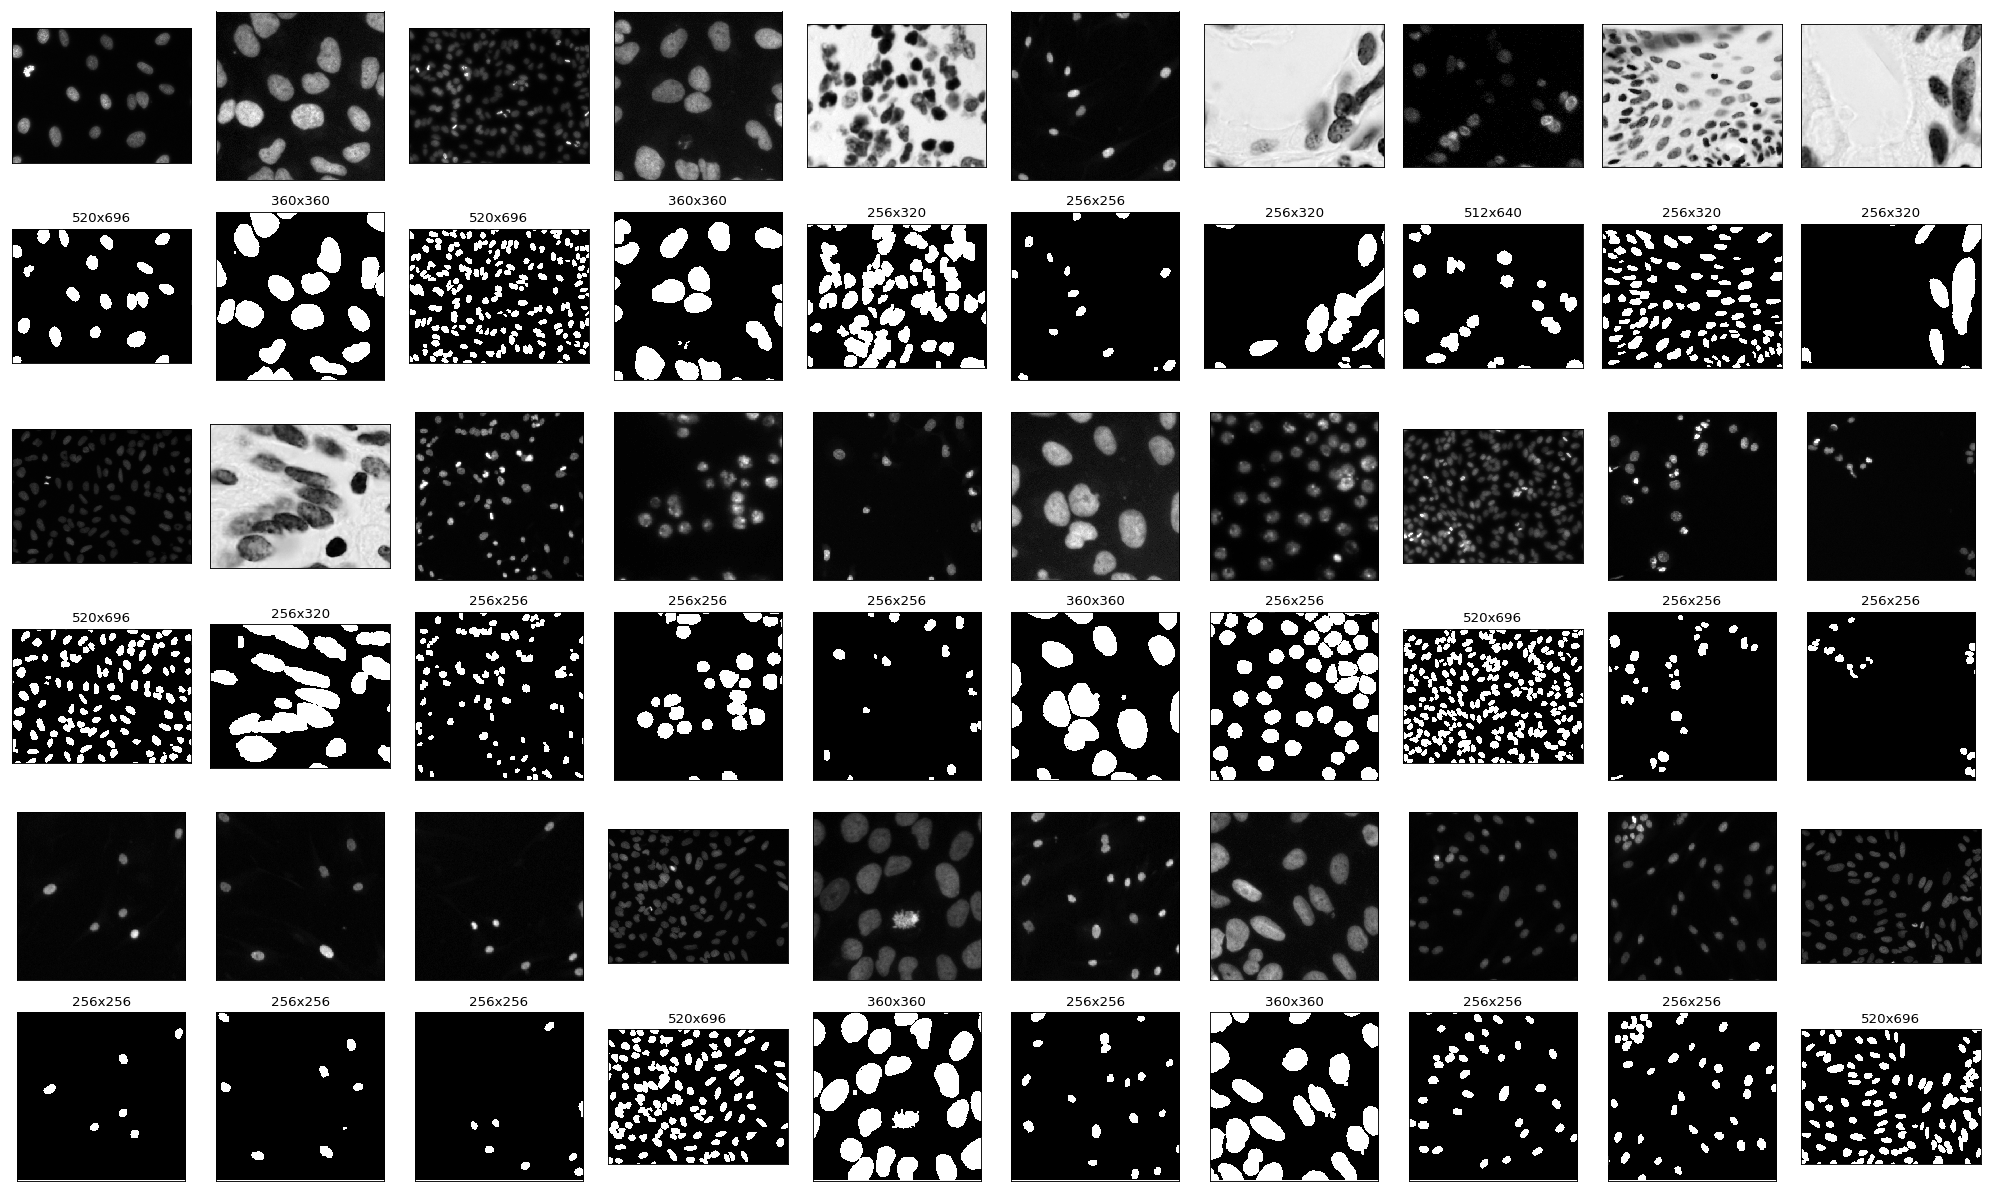

In [10]:
generator = dataset.generator(mode='test')
show_data_from_generator(generator,3, 10, (25,15))

## Setup optimizer

In [11]:
optimizer = keras.optimizers.Adam(lr = learning_rate)

## Build model

In [12]:
builder = Unet(input_shape=input_shape)
model = builder.build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Dataset generators

In [13]:
train_generator = dataset.generator('training', batch_size=batch_size)
valid_generator = dataset.generator('validation', batch_size=10)

## Metrics

In [14]:
def pixel_difference(y_true, y_pred):
    '''
    Custom metrics for comparison of images
    pixel by pixel. 
    '''
    cof = 100/(input_shape[0]*input_shape[1]*batch_size)
    return cof*K.sum(K.abs(y_true - y_pred))

metrics = ['accuracy', pixel_difference]

## Compile model

In [15]:
model.compile(optimizer=optimizer, loss = loss, metrics = metrics)

## Callbacks

In [16]:
# tensor board
tensorboard = keras.callbacks.TensorBoard(log_dir=tensor_board_directory, histogram_freq=0, write_graph=True, write_images=True, update_freq=100)
# image prediction history to be shown in the Tensor board
v_generator = dataset.generator('validation', batch_size=1)
v_data = [next(v_generator) for item in range(3)]
image_history = ImageHistory(tensor_board_dir=tensor_board_directory, data=v_data, last_step=last_step, draw_interval=100)
# model saving at end of an epoch
model_checkpoint = keras.callbacks.ModelCheckpoint(weight_file, monitor='loss',verbose=1, save_best_only=True)

Found 228 images belonging to 1 classes.
Found 228 images belonging to 1 classes.


## Load weights from previous steps

In [17]:
if os.path.isfile(weight_file):
    print('load weights')
    model.load_weights(weight_file)

## Train Model

In [18]:
model.fit_generator(generator=train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, initial_epoch=start_epoch,
                    validation_data=valid_generator, validation_steps=30,
                    callbacks=[model_checkpoint, tensorboard, image_history])

Epoch 1/3
Found 228 images belonging to 1 classes.
Found 1949 images belonging to 1 classes.
Found 228 images belonging to 1 classes.
Found 1949 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


4000/4000 [==============================] - 11584s 3s/step - loss: 0.0580 - acc: 0.9778 - pixel_difference: 3.5328 - val_loss: 0.0590 - val_acc: 0.9826 - val_pixel_difference: 0.9630

Epoch 00001: loss improved from inf to 0.05800, saving model to ./unet_dsb_weights.hdf5
Epoch 2/3
4000/4000 [==============================] - 11453s 3s/step - loss: 0.0108 - acc: 0.9955 - pixel_difference: 0.6450 - val_loss: 0.0957 - val_acc: 0.9831 - val_pixel_difference: 0.8625

Epoch 00002: loss improved from 0.05800 to 0.01075, saving model to ./unet_dsb_weights.hdf5
Epoch 3/3
4000/4000 [==============================] - 11442s 3s/step - loss: 0.0071 - acc: 0.9972 - pixel_difference: 0.4184 - val_loss: 0.1107 - val_acc: 0.9825 - val_pixel_difference: 0.8864

Epoch 00003: loss improved from 0.01075 to 0.00709, saving model to ./unet_dsb_weights.hdf5


## Explore results

In [5]:
def generate_segmentation_mask(model, dataset, image):
    mean = np.mean(image)
    if mean>80:
        image = (255 - image)
    image_tiles = dataset.split_image_to_tiles(image)
    tile_num = len(image_tiles)
    tile_shape = image_tiles[0].shape
    batch = np.zeros((tile_num, tile_shape[0], tile_shape[1], 1))
    for tile_index in range(tile_num):
        tile = image_tiles[tile_index]
        tile = Dataset.normalize_image(tile)
        batch[tile_index,:,:,0] = tile
    mask_batch = model.predict(batch)
    mask_tiles = []
    for tile_index in range(tile_num):
        tile = mask_batch[tile_index,:,:,0]
        mask_tiles.append(tile)
    mask = dataset.combine_image_from_tiles(image.shape, mask_tiles)
    return mask

In [20]:
def show_test_prediction(number_of_test_images, error_threshold):
    t_generator = dataset.generator('test', batch_size=1)

    cols = 10
    rows = (number_of_test_images-1)//cols + 1
    if cols > number_of_test_images:
        cols = number_of_test_images

    plt.figure(figsize=(5*cols, 15*rows))
    item = 0
    for image, label in t_generator:
        mask = generate_segmentation_mask(model, dataset, image)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        label1 = Dataset.normalize_label(label)
        pixel_dif = np.sum(np.abs(mask - label1))/(image.shape[0]*image.shape[1]/100)
        if pixel_dif>=error_threshold:
            row = item//cols
            col = item%cols
            plt.subplot2grid((rows*3,cols),(row*3, col))
            plt.xticks([])
            plt.yticks([])
            plt.title('error=' + str(pixel_dif))
            plt.imshow(image,cmap='gray')
            plt.subplot2grid((rows*3,cols),(row*3+1, col))
            plt.xticks([])
            plt.yticks([])
            plt.imshow(label1,cmap='gray')
            plt.subplot2grid((rows*3,cols),(row*3+2, col))
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask,cmap='gray')
            item += 1
        if item>=number_of_test_images:
            break
    plt.show()
    

### Generate segmentation masks

Show first 30 images from the training set

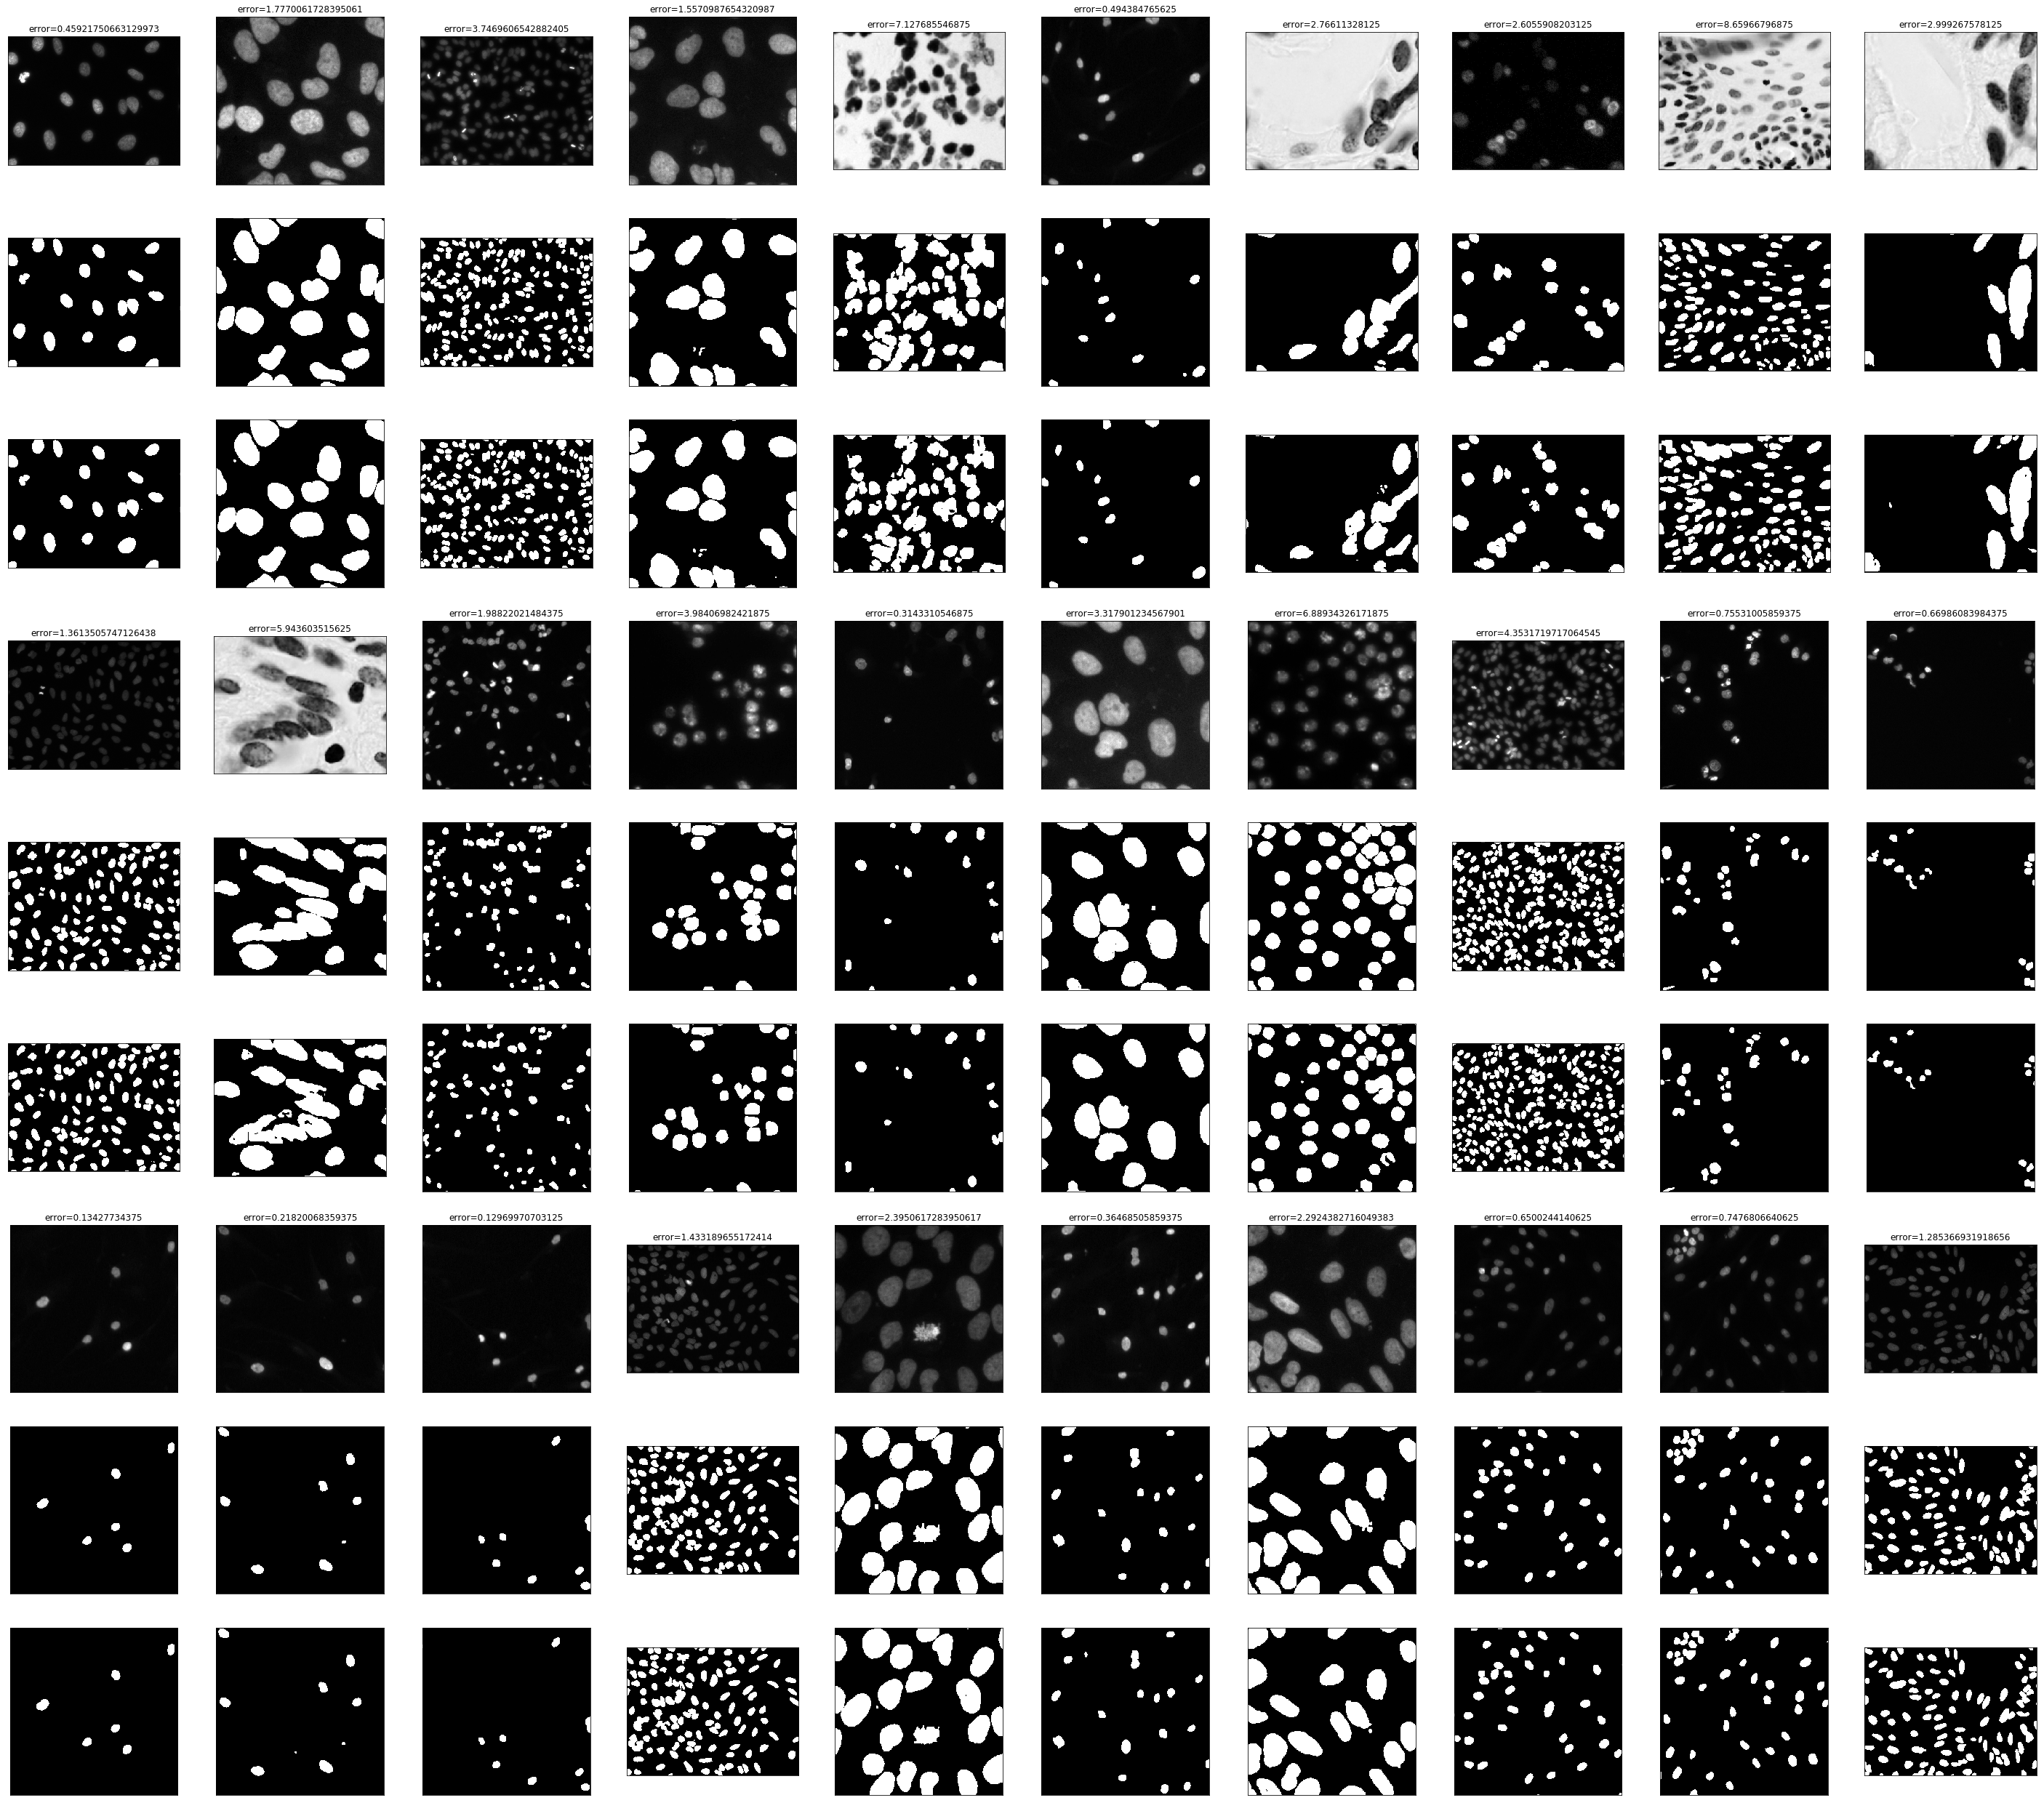

In [21]:
show_test_prediction(30, 0)

Show images with pixel error more than 5%

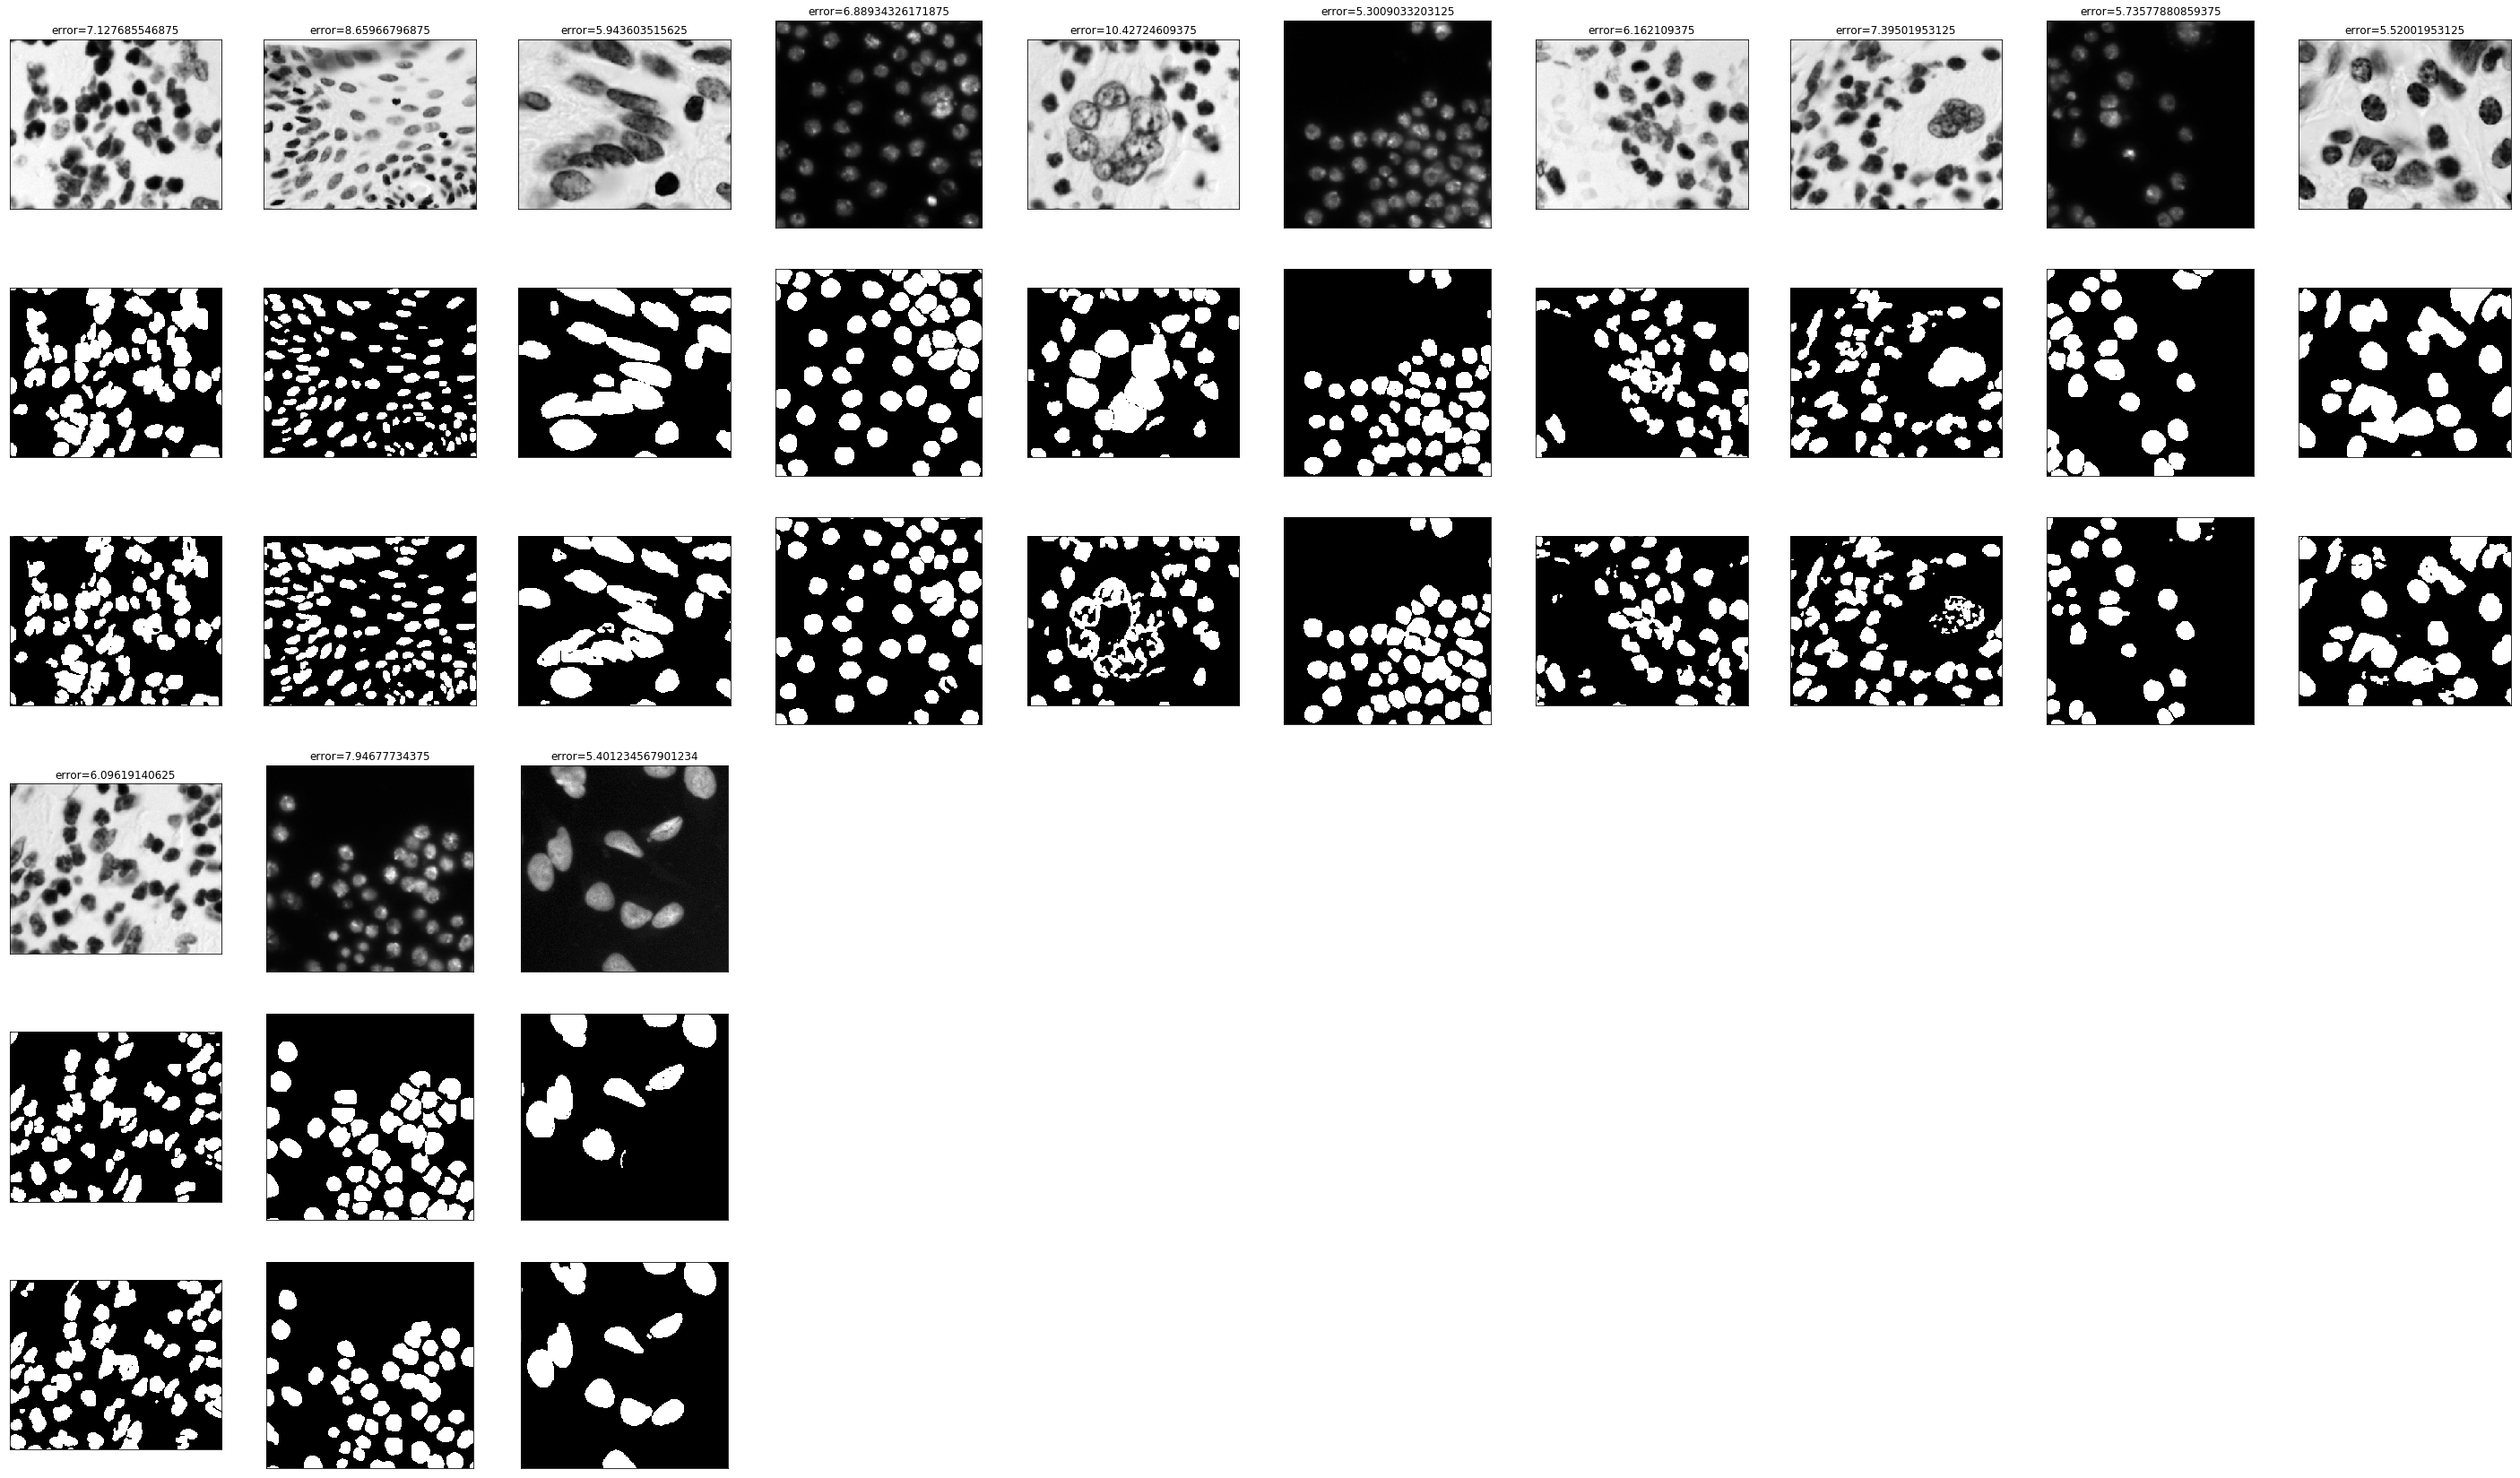

In [22]:
show_test_prediction(30, 5)